In [1]:
from fastbook import *

In [2]:
path = untar_data(URLs.IMAGENETTE_160)

In [3]:
t = get_image_files(path)
t[0]

Path('/root/.fastai/data/imagenette2-160/val/n02102040/n02102040_7082.JPEG')

In [4]:
from glob import glob

In [6]:
files = L(glob(f'{path}/**/*.JPEG',recursive=True)).map(Path)
files[0]

Path('/root/.fastai/data/imagenette2-160/val/n02102040/n02102040_7082.JPEG')

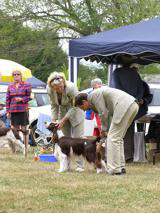

In [7]:
img1 = Image.open(files[0])
img1

In [8]:
img1_t = tensor(img1)
img1_t.shape

torch.Size([213, 160, 3])

In [14]:
lbls = files.map(Self.parent.name()).unique()
lbls

(#10) ['n02102040','n03417042','n03445777','n03425413','n01440764','n03000684','n02979186','n03028079','n03888257','n03394916']

In [15]:
v2i = lbls.val2idx()
v2i

{'n02102040': 0,
 'n03417042': 1,
 'n03445777': 2,
 'n03425413': 3,
 'n01440764': 4,
 'n03000684': 5,
 'n02979186': 6,
 'n03028079': 7,
 'n03888257': 8,
 'n03394916': 9}

In [16]:
class Dataset:
    def __init__(self, fns):
        self.fns = fns
    
    def __len__(self):
        return len(self.fns)
    
    def __getitem__(self,i):
        im = Image.open(self.fns[i]).resize((64,64)).convert('RGB')
        y = v2i[self.fns[i].parent.name]
        return tensor(im).float()/255, tensor(y)

In [17]:
train_filt = L(o.parent.parent.name == 'train' for o in files)
train,valid = files[train_filt], files[~train_filt]
len(train), len(valid)

(9469, 3925)

In [18]:
train_ds, valid_ds = Dataset(train), Dataset(valid)

In [19]:
x,y = train_ds[0]
x.shape, y

(torch.Size([64, 64, 3]), tensor(0))

<AxesSubplot:title={'center':'n02102040'}>

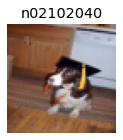

In [20]:
show_image(x, title=lbls[y])

In [24]:
def collate(idxs, ds):
    xb, yb = zip(*[ds[i] for i in idxs])
    return torch.stack(xb), torch.stack(yb)

In [23]:
for i in zip((1,2),(3,4),(5,6)):
    print(i)

(1, 3, 5)
(2, 4, 6)


In [26]:
x, y = collate([1,2], train_ds)
x.shape, y

(torch.Size([2, 64, 64, 3]), tensor([0, 0]))

In [27]:
class DataLoader:
    def __init__(self,ds, bs=128,shuffle=False, n_workers=1):
        self.ds,self.bs,self.shuffle,self.n_workers = ds,bs, shuffle, n_workers
        
    def __len__(self):
        return (len(self.ds) - 1)// self.bs + 1
    
    def __iter__(self):
        idxs = L.range(self.ds)
        if self.shuffle:
            idxs = idxs.shuffle()
            
        chunks = [
            idxs[n:n+self.bs]
            for n in range(0, len(self.ds), self.bs)
        ]
        with ProcessPoolExecutor(self.n_workers) as ex:
            yield from ex.map(collate, chunks, ds=self.ds)
        
        

In [30]:
n_workers = min(8, defaults.cpus)
train_dl = DataLoader(train_ds, bs=128, shuffle=True,n_workers=n_workers)
valid_dl = DataLoader(valid_ds, bs=128, shuffle=True,n_workers=n_workers)
xb, yb = first(train_dl)
xb.shape, yb.shape, len(train_dl)

(torch.Size([128, 64, 64, 3]), torch.Size([128]), 74)

In [31]:
stats = [xb.mean((0,1,2)), xb.std((0,1,2))]
stats

[tensor([0.4754, 0.4765, 0.4611]), tensor([0.2835, 0.2824, 0.3087])]

In [32]:
class Normalize:
    def __init__(self,stats):
        self.stats = stats
        
    def __call__(self, x):
        if x.device != self.stats[0].device:
            self.stats = to_device(self.stats, x.device)
        return (x - self.stats[0]) / self.stats[1]

In [33]:
norm = Normalize(stats)
def tfm_x(x):
    return norm(x).permute((0,3,1,2))

In [35]:
t = tfm_x(x)
t.mean((0,2,3)), t.std((0,2,3))

(tensor([-0.0480, -0.2809, -0.3168]), tensor([0.9383, 0.9511, 1.0825]))

In [36]:
class Parameter(Tensor):
    def __new__(self, x):
        return Tensor._make_subclass(Parameter, x, True)
    
    def __init__(self, *args, **kwargs):
        self.requires_grad_()

In [46]:
class Module():
    def __init__(self):
        self.hook, self.params, self.children, self._training = None, [],[], False
        
    def register_parameters(self, *ps):
        self.params += ps
        
    def register_modules(self,*ms):
        self.children += ms
        
    @property
    def training(self):
        return self._training
    
    @training.setter
    def training(self, v):
        self._training = v
        for m in self.children:
            m.training = v
            
    def parameters(self):
        return self.params + sum([m.parameters() for m in self.children],[])
    
    def __setattr__(self, k,v):
        super().__setattr__(k,v)
        if isinstance(v, Parameter):
            self.register_parameters(v)
        if isinstance(v, Module):
            self.register_modules(v)
    
    def __call__(self, *args, **kwargs):
        res = self.forward(*args, **kwargs)
        if self.hook is not None:
            self.hook(res,args)
        return res
    
    def cuda(self):
        for p in self.parameters():
            p.data = p.data.cuda()

In [39]:
sum([[1,2],[1,2]],[])

[1, 2, 1, 2]

In [47]:
class ConvLayer(Module):
    def __init__(self, ni, nf, stride=1, bias=True, act=True):
        super().__init__()
        self.w = Parameter(torch.zeros(nf,ni,3,3))
        self.b = Parameter(torch.zeros(nf)) if bias else None
        self.act,self.stride = act, stride
        init = nn.init.kaiming_normal_ if act else nn.init.xavier_normal_
        init(self.w)
    
    def forward(self,x):
        x = F.conv2d(x, self.w, self.b, stride=self.stride, padding=1)
        if self.act:
            x = F.relu(x)
            
        return x

In [48]:
l = ConvLayer(3, 4)
len(l.parameters())

2

In [49]:
xbt = tfm_x(xb)
r = l(xbt)
r.shape

(128, 4, 64, 64)

In [54]:
class Linear(Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.w = Parameter(torch.zeros(nf,ni))
        self.b = Parameter(torch.zeros(nf))
        nn.init.xavier_normal_(self.w)
    
    def forward(self, x):
        return x@self.w.t() + self.b

In [55]:
class Sequential(Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = layers
        self.register_modules(*layers)
        
    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return x

In [56]:
class AdaptivePool(Module):
    def forward(self, x):
        return x.mean((2,3))

In [66]:
def simple_cnn():
    return Sequential(
        ConvLayer(3, 16, stride=2),# 32
        ConvLayer(16,32, stride=2), # 16
        ConvLayer(32,64, stride=2), # 8
        ConvLayer(64,128, stride=2), # 4
        AdaptivePool(),
        Linear(128,10)
    )

In [58]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

In [59]:
def log_softmax(x):
    return (x.exp()/(x.exp().sum(-1, keepdim=True))).log()

In [67]:
m = simple_cnn()
r = m(xbt)

In [68]:
sm = log_softmax(r)
sm.shape

(128, 10)

In [69]:
loss = nll(sm, yb)

In [72]:
loss

tensor(2.7092, grad_fn=<AliasBackward>)

In [79]:
sm[range(128),yb].shape

(128,)

In [82]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [83]:
def log_softmax(x):
    return x - x.logsumexp(-1, keepdim=True)

In [84]:
def cross_entropy(preds,yb):
    return nll(log_softmax(preds), yb).mean()

In [85]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        store_attr()
    
    def step(self):
        for p in self.params:
            p.data -= (p.grad.data + p.data*self.wd)*self.lr
            p.grad.data.zero_()

In [87]:
class DataLoaders:
    def __init__(self, *dls):
        self.train,self.valid = dls
        
dls = DataLoaders(train_dl,valid_dl)

In [95]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func = SGD):
        store_attr()
        for cb in cbs: cb.learner = self
            
    def one_batch(self):
        self('before_batch')
        xb,yb = self.batch
        self.preds = self.model(xb)
        self.loss = self.loss_func(self.preds, yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            
        self('after_batch')
        
    def one_epoch(self,train):
        self.model.training = train
        self('before_epoch')
        dl = self.dls.train if train else self.dls.valid
        for self.num, self.batch in enumerate(progress_bar(dl,leave=False)):
            self.one_batch()
        self('after_epoch')
        
    def fit(self, n_epochs):
        self('before_fit')
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        try:
            for self.epoch in range(n_epochs):
                self.one_epoch(True)
                self.one_epoch(False)
            
        except CancelFitException:pass
        
        self('after_fit')
        
    def __call__(self,name):
        for cb in self.cbs:
            getattr(cb, name,noop)()

In [91]:
class Callback(GetAttr):
    _default='learner'

In [92]:
class SetupLearnerCB(Callback):
    def before_batch(self):
        xb,yb = to_device(self.batch)
        self.learner.batch = tfm_x(xb), yb
    
    def before_fit(self):
        self.model.cuda()

In [93]:
class TrackResults(Callback):
    def before_epoch(self):
        self.accs, self.losses, self.ns = [],[],[]
        
    def after_epoch(self):
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
        
    def after_batch(self):
        xb, yb =self.batch
        acc = (self.preds.argmax(dim=1) == yb).float().sum()
        self.accs.append(acc)
        n = len(xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

In [96]:
cbs = [SetupLearnerCB(), TrackResults()]
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

0 True 2.1064225201974867 0.23666701869257578


0 False 2.012595043789809 0.2677707006369427


In [98]:
class LRFinder(Callback):
    def before_fit(self):
        self.losses, self.lrs = [],[]
        self.learner.lr = 1e-6
        
    def before_batch(self):
        if not self.model.training: return
        self.opt.lr *= 1.2
    
    def after_batch(self):
        if not self.model.training: return
        if self.opt.lr > 10 or torch.isnan(self.loss):
            raise CancelFitException
        self.losses.append(self.loss.item())
        self.lrs.append(self.opt.lr)

In [99]:
lrfind = LRFinder()
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[lrfind])
learn.fit(2)

0 True 2.4763116815397614 0.11236667018692575


0 False 2.3322832902070063 0.09961783439490446


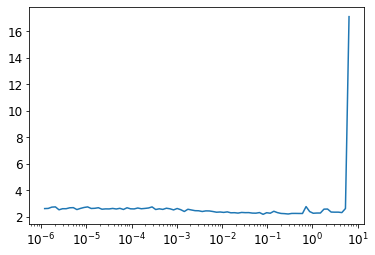

In [100]:
plt.plot(lrfind.lrs[:-2], lrfind.losses[:-2])
plt.xscale('log')

In [101]:
class OneCycle(Callback):
    def __init__(self, base_lr):
        self.base_lr = base_lr
        
    def before_fit(self):
        self.lrs = []
        
    def before_batch(self):
        if not self.model.training: return
        n = len(self.dls.train)
        bn = self.epoch*n + self.num
        mn = self.n_epochs*n
        pct = bn/mn
        pct_start, div_start = 0.25, 10
        if pct<pct_start:
            pct/=pct_start
            lr = (1-pct)*self.base_lr/div_start +pct*self.base_lr
            
        else:
            pct = (pct-pct_start)/(1-pct_start)
            lr = (1-pct)*self.base_lr
        self.opt.lr = lr
        self.lrs.append(lr)
            

In [102]:
onecyc = OneCycle(0.1)
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs = cbs+[onecyc])

In [ ]:
learn.fit(8)

0 True 2.238938823397402 0.17076776850776218


0 False 2.204781050955414 0.18394904458598726


1 True 2.075143436806949 0.2563100644207414


1 False 2.014591958598726 0.26828025477707007


2 True 1.948474957756891 0.31017002851409864


2 False 1.8768006070859873 0.3436942675159236


3 True 1.854391220693843 0.3636075615165276


3 False 1.8734225716560509 0.3281528662420382


4 True 1.7474841835859118 0.3989861653817721


4 False 1.7733761693869428 0.39031847133757963


5 True 1.6758767507788572 0.42274791424648855


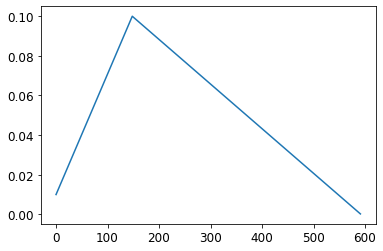

In [104]:
plt.plot(onecyc.lrs)